In [42]:
from collections import namedtuple
import time
import os
import numpy as np
import sys
import torch
from tqdm import tqdm
from dress_code_data import DressCodeDataLoader, DressCodeDataset

# from utils import sem2onehot
import argparse
from matplotlib import pyplot as plt
import PIL
from torchvision.transforms import ToPILImage,Grayscale,ToTensor

import cv2
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from PIL import Image, ImageDraw
import os
import numpy as np
import json
from typing import List, Tuple
from dress_code_data.labelmap import label_map
from numpy.linalg import lstsq


In [20]:
class DressCodeDatasetAnyDoor(data.Dataset):
    def __init__(
        self,
        args,
        dataroot_path: str,
        phase: str,
        order: str = "paired",
        category: List[str] = ["dresses", "upper_body", "lower_body"],
        size: Tuple[int, int] = (256, 192),
    ):
        """
        Initialize the PyTroch Dataset Class
        :param args: argparse parameters
        :type args: argparse
        :param dataroot_path: dataset root folder
        :type dataroot_path:  string
        :param phase: phase (train | test)
        :type phase: string
        :param order: setting (paired | unpaired)
        :type order: string
        :param category: clothing category (upper_body | lower_body | dresses)
        :type category: list(str)
        :param size: image size (height, width)
        :type size: tuple(int)
        """
        super(DressCodeDatasetAnyDoor, self).__init__()
        self.args = args
        self.dataroot = dataroot_path
        self.phase = phase
        self.category = category
        self.height = size[0]
        self.width = size[1]
        self.radius = args.radius
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        self.transform2D = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        )

        im_names = []
        c_names = []
        dataroot_names = []

        for c in category:
            assert c in ["dresses", "upper_body", "lower_body"]

            dataroot = os.path.join(self.dataroot, c)
            if phase == "train":
                filename = os.path.join(dataroot, f"{phase}_pairs.txt")
            else:
                filename = os.path.join(dataroot, f"{phase}_pairs_{order}.txt")
            with open(filename, "r") as f:
                for line in f.readlines():
                    im_name, c_name = line.strip().split()
                    im_names.append(im_name)
                    c_names.append(c_name)
                    dataroot_names.append(dataroot)

        self.im_names = im_names
        self.c_names = c_names
        self.dataroot_names = dataroot_names

    def __getitem__(self, index):
        """
        For each index return the corresponding sample in the dataset
        :param index: data index
        :type index: int
        :return: dict containing dataset samples
        :rtype: dict
        """
        c_name = self.c_names[index]
        im_name = self.im_names[index]
        dataroot = self.dataroot_names[index]

        # Clothing image and mask
        ref_image = cv2.imread(os.path.join(dataroot, "images", c_name))
        ref_image = cv2.cvtColor(ref_image, cv2.COLOR_BGR2RGB)
        ref_mask = (ref_image < 255).astype(np.uint8)[:, :, 0]

        # Person image
        im = Image.open(os.path.join(dataroot, "images", im_name))

        # Label Map
        parse_name = im_name.replace("_0.jpg", "_4.png")
        im_parse = Image.open(os.path.join(dataroot, "label_maps", parse_name))
        im_parse = im_parse.resize((self.width, self.height), Image.NEAREST)
        parse_array = np.array(im_parse)

        parse_shape = (parse_array > 0).astype(np.float32)

        parse_head = (
            (parse_array == 1).astype(np.float32)
            + (parse_array == 2).astype(np.float32)
            + (parse_array == 3).astype(np.float32)
            + (parse_array == 11).astype(np.float32)
        )

        parser_mask_fixed = (
            (parse_array == label_map["hair"]).astype(np.float32)
            + (parse_array == label_map["left_shoe"]).astype(np.float32)
            + (parse_array == label_map["right_shoe"]).astype(np.float32)
            + (parse_array == label_map["hat"]).astype(np.float32)
            + (parse_array == label_map["sunglasses"]).astype(np.float32)
            + (parse_array == label_map["scarf"]).astype(np.float32)
            + (parse_array == label_map["bag"]).astype(np.float32)
        )

        parser_mask_changeable = (parse_array == label_map["background"]).astype(
            np.float32
        )

        arms = (parse_array == 14).astype(np.float32) + (parse_array == 15).astype(
            np.float32
        )

        if dataroot.split("/")[-1] == "dresses":
            label_cat = 7
            parse_cloth = (parse_array == 7).astype(np.float32)
            parse_mask = (
                (parse_array == 7).astype(np.float32)
                + (parse_array == 12).astype(np.float32)
                + (parse_array == 13).astype(np.float32)
            )
            parser_mask_changeable += np.logical_and(
                parse_array, np.logical_not(parser_mask_fixed)
            )

        elif dataroot.split("/")[-1] == "upper_body":
            label_cat = 4
            parse_cloth = (parse_array == 4).astype(np.float32)
            parse_mask = (parse_array == 4).astype(np.float32)

            parser_mask_fixed += (parse_array == label_map["skirt"]).astype(
                np.float32
            ) + (parse_array == label_map["pants"]).astype(np.float32)

            parser_mask_changeable += np.logical_and(
                parse_array, np.logical_not(parser_mask_fixed)
            )
        elif dataroot.split("/")[-1] == "lower_body":
            label_cat = 6
            parse_cloth = (parse_array == 6).astype(np.float32)
            parse_mask = (
                (parse_array == 6).astype(np.float32)
                + (parse_array == 12).astype(np.float32)
                + (parse_array == 13).astype(np.float32)
            )

            parser_mask_fixed += (
                (parse_array == label_map["upper_clothes"]).astype(np.float32)
                + (parse_array == 14).astype(np.float32)
                + (parse_array == 15).astype(np.float32)
            )
            parser_mask_changeable += np.logical_and(
                parse_array, np.logical_not(parser_mask_fixed)
            )

        parse_head = torch.from_numpy(parse_head)  # [0,1]
        parse_cloth = torch.from_numpy(parse_cloth)  # [0,1]
        parse_mask = torch.from_numpy(parse_mask)  # [0,1]
        parser_mask_fixed = torch.from_numpy(parser_mask_fixed)
        parser_mask_changeable = torch.from_numpy(parser_mask_changeable)

        # dilation
        parse_without_cloth = np.logical_and(parse_shape, np.logical_not(parse_mask))
        parse_mask = parse_mask.cpu().numpy()

        # Shape
        parse_shape = Image.fromarray((parse_shape * 255).astype(np.uint8))
        parse_shape = parse_shape.resize(
            (self.width // 16, self.height // 16), Image.BILINEAR
        )
        parse_shape = parse_shape.resize((self.width, self.height), Image.BILINEAR)
        shape = self.transform2D(parse_shape)  # [-1,1]

        # Load pose points
        pose_name = im_name.replace("_0.jpg", "_2.json")
        with open(os.path.join(dataroot, "keypoints", pose_name), "r") as f:
            pose_label = json.load(f)
            pose_data = pose_label["keypoints"]
            pose_data = np.array(pose_data)
            pose_data = pose_data.reshape((-1, 4))

        point_num = pose_data.shape[0]
        pose_map = torch.zeros(point_num, self.height, self.width)
        r = self.radius * (self.height / 512.0)
        im_pose = Image.new("L", (self.width, self.height))
        pose_draw = ImageDraw.Draw(im_pose)
        neck = Image.new("L", (self.width, self.height))
        neck_draw = ImageDraw.Draw(neck)
        for i in range(point_num):
            one_map = Image.new("L", (self.width, self.height))
            draw = ImageDraw.Draw(one_map)
            point_x = np.multiply(pose_data[i, 0], self.width / 384.0)
            point_y = np.multiply(pose_data[i, 1], self.height / 512.0)
            if point_x > 1 and point_y > 1:
                draw.rectangle(
                    (point_x - r, point_y - r, point_x + r, point_y + r),
                    "white",
                    "white",
                )
                pose_draw.rectangle(
                    (point_x - r, point_y - r, point_x + r, point_y + r),
                    "white",
                    "white",
                )
                if i == 2 or i == 5:
                    neck_draw.ellipse(
                        (
                            point_x - r * 4,
                            point_y - r * 4,
                            point_x + r * 4,
                            point_y + r * 4,
                        ),
                        "white",
                        "white",
                    )
            one_map = self.transform2D(one_map)
            pose_map[i] = one_map[0]

        # just for visualization
        im_pose = self.transform2D(im_pose)

        im_arms = Image.new("L", (self.width, self.height))
        arms_draw = ImageDraw.Draw(im_arms)
        if (
            dataroot.split("/")[-1] == "dresses"
            or dataroot.split("/")[-1] == "upper_body"
        ):
            with open(os.path.join(dataroot, "keypoints", pose_name), "r") as f:
                data = json.load(f)
                shoulder_right = np.multiply(
                    tuple(data["keypoints"][2][:2]), self.height / 512.0
                )
                shoulder_left = np.multiply(
                    tuple(data["keypoints"][5][:2]), self.height / 512.0
                )
                elbow_right = np.multiply(
                    tuple(data["keypoints"][3][:2]), self.height / 512.0
                )
                elbow_left = np.multiply(
                    tuple(data["keypoints"][6][:2]), self.height / 512.0
                )
                wrist_right = np.multiply(
                    tuple(data["keypoints"][4][:2]), self.height / 512.0
                )
                wrist_left = np.multiply(
                    tuple(data["keypoints"][7][:2]), self.height / 512.0
                )
                if wrist_right[0] <= 1.0 and wrist_right[1] <= 1.0:
                    if elbow_right[0] <= 1.0 and elbow_right[1] <= 1.0:
                        arms_draw.line(
                            np.concatenate(
                                (wrist_left, elbow_left, shoulder_left, shoulder_right)
                            )
                            .astype(np.uint16)
                            .tolist(),
                            "white",
                            30,
                            "curve",
                        )
                    else:
                        arms_draw.line(
                            np.concatenate(
                                (
                                    wrist_left,
                                    elbow_left,
                                    shoulder_left,
                                    shoulder_right,
                                    elbow_right,
                                )
                            )
                            .astype(np.uint16)
                            .tolist(),
                            "white",
                            30,
                            "curve",
                        )
                elif wrist_left[0] <= 1.0 and wrist_left[1] <= 1.0:
                    if elbow_left[0] <= 1.0 and elbow_left[1] <= 1.0:
                        arms_draw.line(
                            np.concatenate(
                                (
                                    shoulder_left,
                                    shoulder_right,
                                    elbow_right,
                                    wrist_right,
                                )
                            )
                            .astype(np.uint16)
                            .tolist(),
                            "white",
                            30,
                            "curve",
                        )
                    else:
                        arms_draw.line(
                            np.concatenate(
                                (
                                    elbow_left,
                                    shoulder_left,
                                    shoulder_right,
                                    elbow_right,
                                    wrist_right,
                                )
                            )
                            .astype(np.uint16)
                            .tolist(),
                            "white",
                            30,
                            "curve",
                        )
                else:
                    arms_draw.line(
                        np.concatenate(
                            (
                                wrist_left,
                                elbow_left,
                                shoulder_left,
                                shoulder_right,
                                elbow_right,
                                wrist_right,
                            )
                        )
                        .astype(np.uint16)
                        .tolist(),
                        "white",
                        30,
                        "curve",
                    )

            if self.args.height > 512:
                im_arms = cv2.dilate(
                    np.float32(im_arms), np.ones((10, 10), np.uint16), iterations=5
                )
            # elif self.args.height > 256:
            #     im_arms = cv2.dilate(np.float32(im_arms), np.ones((5, 5), np.uint16), iterations=5)
            hands = np.logical_and(np.logical_not(im_arms), arms)
            parse_mask += im_arms
            parser_mask_fixed += hands

        # delete neck
        parse_head_2 = torch.clone(parse_head)
        if (
            dataroot.split("/")[-1] == "dresses"
            or dataroot.split("/")[-1] == "upper_body"
        ):
            with open(os.path.join(dataroot, "keypoints", pose_name), "r") as f:
                data = json.load(f)
                points = []
                points.append(
                    np.multiply(tuple(data["keypoints"][2][:2]), self.height / 512.0)
                )
                points.append(
                    np.multiply(tuple(data["keypoints"][5][:2]), self.height / 512.0)
                )
                x_coords, y_coords = zip(*points)
                A = np.vstack([x_coords, np.ones(len(x_coords))]).T
                m, c = lstsq(A, y_coords, rcond=None)[0]
                for i in range(parse_array.shape[1]):
                    y = i * m + c
                    parse_head_2[int(y - 20 * (self.height / 512.0)) :, i] = 0

        parser_mask_fixed = np.logical_or(
            parser_mask_fixed, np.array(parse_head_2, dtype=np.uint16)
        )
        parse_mask += np.logical_or(
            parse_mask,
            np.logical_and(
                np.array(parse_head, dtype=np.uint16),
                np.logical_not(np.array(parse_head_2, dtype=np.uint16)),
            ),
        )

        if self.args.height > 512:
            parse_mask = cv2.dilate(
                parse_mask, np.ones((20, 20), np.uint16), iterations=5
            )
        # elif self.args.height > 256:
        #     parse_mask = cv2.dilate(parse_mask, np.ones((10, 10), np.uint16), iterations=5)
        else:
            parse_mask = cv2.dilate(
                parse_mask, np.ones((5, 5), np.uint16), iterations=5
            )
        parse_mask = np.logical_and(parser_mask_changeable, np.logical_not(parse_mask))
        parse_mask_total = np.logical_or(parse_mask, parser_mask_fixed)
        im_mask = im * parse_mask_total

        result = {
            "cloth": ref_image,
            "model_image": im,
            "model_mask": im_mask,
            "cloth_mask": ref_mask,
        }

        return result

    def __len__(self):
        return len(self.c_names)



In [43]:
def test_unpaired(dataloader, model, e, args):
    with tqdm(
        desc="Iteration %d - images extraction" % e,
        unit="it",
        total=len(dataloader.data_loader),
    ) as pbar:
        for step in range(0, len(dataloader.data_loader)):
            inputs = dataloader.next_batch()

            with torch.no_grad():
                image_name = inputs["im_name"]
                cloth_name = inputs["c_name"]
                image = inputs["image"].cuda()
                cloth = inputs["cloth"].cuda()
                cropped_cloth = inputs["im_cloth"].cuda()
                im_head = inputs["im_head"].cuda()
                pose_map = inputs["pose_map"].cuda()
                skeleton = inputs["skeleton"].cuda()
                im_pose = inputs["im_pose"].cuda()
                shape = inputs["shape"].cuda()
                parse_array = inputs["parse_array"].cuda()
                dense_labels = inputs["dense_labels"].cuda()
                dense_uv = inputs["dense_uv"].cuda()

                parse_array = sem2onehot(18, parse_array)

                # model here

def training_loop(dataloader, model, e, args):

    with tqdm(
        desc="Iteration %d - train" % e, unit="it", total=args.display_count
    ) as pbar:
        for step in range(0, args.display_count):
            inputs = dataloader.next_batch()

            image_name = inputs["im_name"]
            cloth_name = inputs["c_name"]
            image = inputs["image"].cuda()
            cloth = inputs["cloth"].cuda()
            cropped_cloth = inputs["im_cloth"].cuda()
            im_head = inputs["im_head"].cuda()
            pose_map = inputs["pose_map"].cuda()
            skeleton = inputs["skeleton"].cuda()
            im_pose = inputs["im_pose"].cuda()
            shape = inputs["shape"].cuda()
            parse_array = inputs["parse_array"].cuda()
            dense_labels = inputs["dense_labels"].cuda()
            dense_uv = inputs["dense_uv"].cuda()

            parse_array = sem2onehot(18, parse_array)

            # model here

            pbar.update()

def main_worker(args):

    # Dataset & Dataloader
    dataset_train = DressCodeDataset(
        args,
        dataroot_path=args.dataroot,
        phase="train",
        order="paired",
        size=(int(args.height), int(args.width)),
    )

    dataloader_train = torch.utils.data.DataLoader(dataset_train)

    return iter(dataloader_train)

In [44]:
args = argparse.Namespace(batch_size=8, category='all', checkpoint_dir='', data_pairs='{}_pairs', dataroot='/opt/dlami/nvme/DressCode', display_count=1000, epochs=150, exp_name='', height=1024, radius=5, shuffle=True, step=100000, width=768, workers=0)

# Call main worker
sample_it  = main_worker(args)

In [45]:
ref_image = cv2.imread('/opt/dlami/nvme/DressCode/dresses/images/020716_1.jpg')
ref_image = cv2.cvtColor(ref_image, cv2.COLOR_BGR2RGB)
ref_mask = (ref_image < 255).astype(np.uint8)[:, :, 0]
model_image = cv2.imread('/opt/dlami/nvme/DressCode/dresses/images/020716_0.jpg')
model_image = cv2.cvtColor(model_image, cv2.COLOR_BGR2RGB)


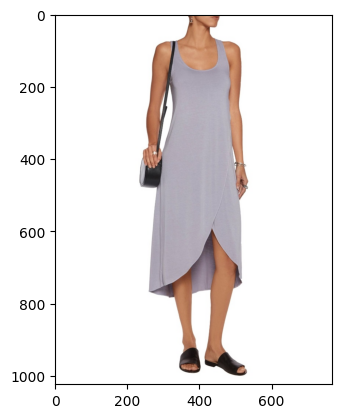

In [46]:
plt.imshow(model_image)
plt.show()

In [47]:
sample = next(sample_it)

/home/ubuntu/mnt/myData/AnyDoor/.venv/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [159]:
mask = (sample["cloth"][0] < 1).numpy().astype(np.uint8)[0]

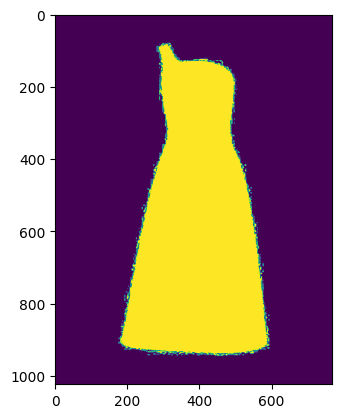

In [160]:
plt.imshow(mask)
plt.show()

In [ ]:
torch.set_printoptions(threshold=float('inf'))

In [5]:
sample["cloth"][0]

NameError: name 'sample' is not defined

In [6]:
mask_image = sample["cloth"]
mask_image.show()

NameError: name 'sample' is not defined

In [132]:
torch.set_printoptions(threshold=float('inf'))
with open("output.txt", "w") as file:  
    print(sample["cloth"][0], file = file)

In [49]:
sample["m"]

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])

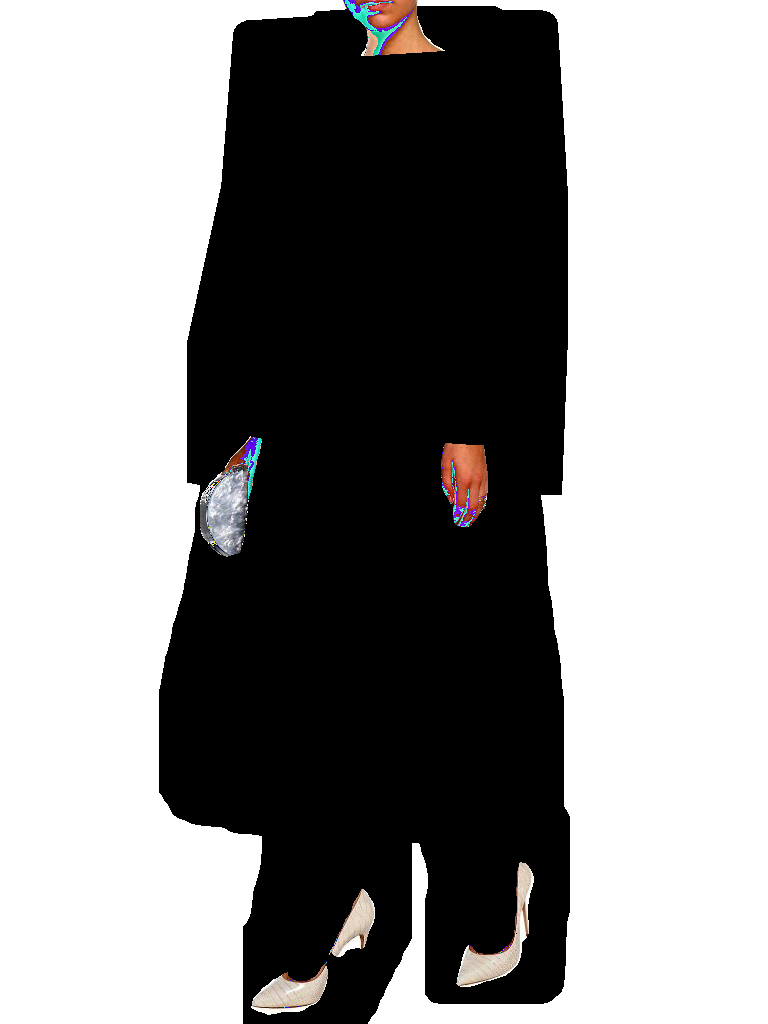

In [48]:

to_pil_image = ToPILImage()
img = to_pil_image(sample["m"][0])

# Display the image
img.show()

In [118]:
grayscale_transform = Grayscale(num_output_channels=1)
gray_tensor = grayscale_transform(sample["cloth"][0])

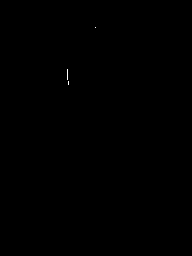

In [119]:
threshold = 0.5
mask_tensor = gray_tensor < threshold

# Convert the boolean mask back to an image for visualization
to_pil_image = ToPILImage()
mask_image = to_pil_image(mask_tensor.float())

# Display the mask
mask_image.show()

TypeError: Invalid shape (3, 256, 192) for image data

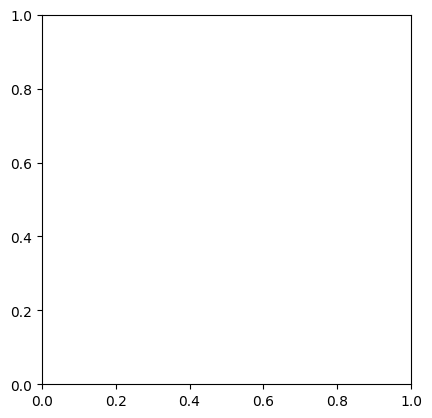

In [9]:
for key in ["cloth"]:
    plt.imshow(sample[key][0], interpolation='nearest')
    plt.show()